A note book for extracting ENA from trained RNNs

In [ ]:
#%%
import numpy as np
import networkx as nx # for network analysis
from copy import deepcopy, copy
import random
from matplotlib import pyplot as plt
# %%
# def remove_two_loops(B):
#     '''
#     removes 2-loops 

#     2-loops are remove by severing one of the connections: the one leading to the
#     node with fewer number of outgoing direction except if the # of outgoing direction
#     is 1.  
#     '''
#     n = B.shape[0]
#     A = copy(B)
#     J = list()
#     for i in range(n):
#         for j in range(i+1, n):
#             if {i, j} not in J and A[i, j] + A[j, i] == 2:
#                 ix = [i, j]
#                 random.shuffle(ix)
#                 A[ix[0], ix[1]] = 0
#             J.append({i, j})
#     return A

def remove_two_loops(B):
    B = copy(B)
    n = B.shape[0]
    B2 = np.matmul(B, B)
    paths_of_2 = list(np.where(B2.diagonal())[0])
    index_tracker = list()
    while len(index_tracker) != len(paths_of_2):
        start = paths_of_2[0]
        end = list(np.where(B[start, :])[0])
        B[start, end] = 0
        index_tracker += [start] + end
    return B




def remove_delta_cliques(B):
    '''
    removes delta cliques by removing the shortest connnection between the nodes
    involved
    '''
    A = deepcopy(B)
    A2 = np.bool_(np.matmul(A, A))
    if A2.sum() != 0:
        indx = np.where(A + A2 == 2)
        A[indx[0], indx[1]] = 0
    return A

def in_neighbours(i, A):
    '''
    returns the in-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[:, i-1])[0]

def out_neighbours(i, A):
    '''
    returns the out-neihbours of i using the adjacency matrix A
    '''
    return np.where(A[i-1, :])[0]

def intersection(list1, list2):
    return list(set(list1) & set(list2))

import networkx as nx
def convert_to_nx(A):
    '''
    converts A into a networkx digraph
    '''
    G = nx.DiGraph(directed=True)
    out = list()
    n = A.shape[0]
    # letters provide labelling
    LETTERS = [str(i) for i in range(n)]
    for i in range(n):
        out.extend([(LETTERS[i], LETTERS[k]) for k in np.where(A[i, :])[0]])
    G.add_edges_from(out)
    return G


In [ ]:
#%%
A = np.array([
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]])

B = remove_delta_cliques(A)


#%%
rnn_size = 20
sparsity = 0.9 * 1/rnn_size
A = np.random.binomial(1, sparsity, (rnn_size, rnn_size))
np.fill_diagonal(A, 0)
A = remove_two_loops(A)
# print(A)
#%%
G = convert_to_nx(A)
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
#%%

In [ ]:
A = np.zeros((rnn_size, rnn_size))
A[:4, :4] = [[0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]]
G = convert_to_nx(A)
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, edge_color = 'k'); plt.show()
# %%
A = np.array([
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0]])

In [ ]:
import torch
from generate_flip_flop import *
import pickle
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)

keys = list(params.keys())
reservoir = params[keys[0]]
ridge = params[keys[1]]

Wr, Win, Wfb = torch.tensor(reservoir['W'].toarray()), \
                       torch.tensor(reservoir['Win'].toarray()), \
                       torch.tensor(reservoir['Wfb'].toarray())
# Wout = ridge['Wout']

In [ ]:
# testing model
with open('train_test.pkl', 'rb') as f:
    x_train, y_train = pickle.load(f)

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge
n_neurons = 500
reservoir = Reservoir(n_neurons, sr=0.9, rc_connectivity=0.05, lr = 1, 
        input_bias=False)
readout = Ridge(ridge=1e-4, input_bias=False)
# This force learning uses a single layer online neural network. 
# readout = FORCE(alpha=1e-6)


reservoir <<= readout  ## feedback
esn = reservoir >> readout
esn = esn.fit(x_train, y_train)

# readout.Wout = Wout
# reservoir.Wfb = Wfb
# reservoir.W = Wr

In [ ]:
preds = esn.run(x_train)

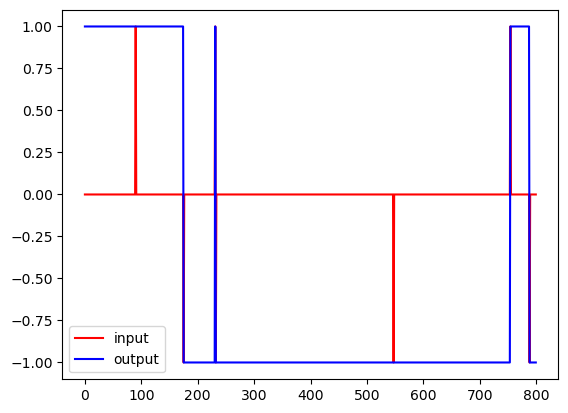

In [348]:
n_start = 300
n_steps = 800
d = 0
# plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
plt.plot(x_train[n_start:(n_start + n_steps), d], 'r-', label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y_train[n_start:(n_start + n_steps), d], 'b-', label='output')
plt.legend()
plt.show()

In [380]:
N_new = 10000
x_new, y_new, _ = sequence(N_new, 0.03, 1, 1)

In [381]:
pred_new_data = esn.run(x_new)

Running Model-0: 10000it [00:02, 3872.06it/s]         


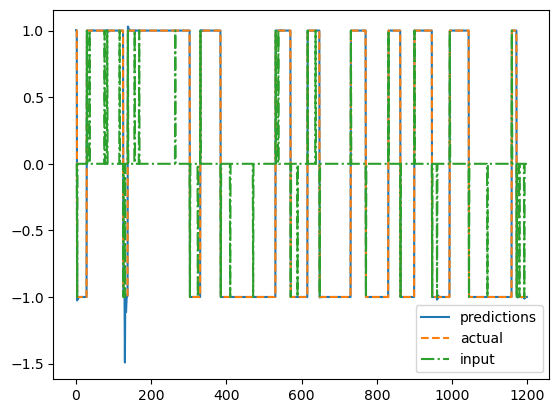

In [382]:
n_start = 3000
# n_steps = x_test.shape[0]
n_steps = 1200
d = 0
plt.plot(pred_new_data[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_new[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
plt.plot(x_new[n_start:(n_start + n_steps), d], label='input', linestyle='-.')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn

def weight_matrix(A, p, w_p):
    w_m, w_s, w_t = p
    return w_s + (w_s - w_t)*torch.eye(A.shape[0]) + (w_p - w_t)*A.T + (w_m - w_t)*A

def activation(x, beta):
    return 1/(1+torch.exp(-beta*(x-0.5)))

def cutt_off(x):
    cond1 = x <= 0
    cond2 = x > 0
    x[cond1] = 0
    x[cond2] =  torch.exp(-1/x[cond2])
    return x

def c_activation(x, beta):
    c = cutt_off(x)
    return c/(c + cutt_off(1-x))


In [389]:
class ENA_extractor(nn.Module):
    def __init__(self, k, beta_init, p_init, Wp, n_out, n_in, scalings, A):
        '''
        n: dimension of phase space
        beta_init: initial value of the gain parameter in 
                
                y = 1/(1+exp(-beta*x))
        p_init: contain the initial values of floats w_m, w_p, w_s, w_t in that
        order.
        A: gives the adjacency matrix
        scalings: contained scalings for Win, Wout, Wfb in that other
        '''
        super().__init__()
        # if A is None:
        #     A = np.random.binomial(1, sparsity, (n,n))
        #     np.fill_diagonal(A, 0)
        #     A = remove_two_loops(A)
        self.A = A
        self.n = A.shape[0]
        self.n_in = n_in
        self.n_out = n_out
        self.scalings = torch.nn.Parameter(scalings.requires_grad_())
        # self.p = torch.nn.Parameter(p_init.requires_grad_())
        self.p = p_init
        # print(beta_init)
        self.beta = torch.nn.Parameter(beta_init.requires_grad_())
        # self.beta = torch.nn.Parameter(beta_init)
        # self.Win = torch.nn.Parameter(torch.randn(k, n_in).requires_grad_())
        self.Win = torch.randn(k, n_in)
        # self.Wout = torch.nn.Parameter(torch.randn(k, n_out).requires_grad_())
        self.Wout = torch.randn(k, n_out)
        self.Wp = torch.nn.Parameter(Wp.requires_grad_())
        self.bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())
        self.Wfb = torch.randn(n_out, k)
        # self.Wfb = torch.nn.Parameter(torch.randn(n_out, k).requires_grad_())
        # self.bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())
    # def forward(self, input_drive, seq_len, beta, h = 0.1):
    def forward(self, trained_rnn, y_curr, h = 1):
        '''
        '''
        # number of nodes in the ENA
        n = self.n
        # scalings of weight matrices
        s_in, s_out, s_fb = self.scalings
        # weight matrices
        Wout = s_out*self.Wout
        Win = s_in*self.Win
        Wfb = s_fb*self.Wfb
        # gain parameter
        beta = self.beta
        # Wp control transitions
        Wp = self.Wp
        bias = self.bias
        # A is the adjacency matrix
        A = self.A
        # p contains other parameters like w_s, w_t and w_m
        p = self.p
        x = torch.zeros(1, n)
        # x[:, 0] = 1
        W = weight_matrix(A, p, Wp)
        # h_out = self.forward_euler(x, W, Win, h, input_drive, beta, bias)
        h_out = self.forward_euler(x, W, Win, Wfb, h, y_curr, trained_rnn, beta)
        # print(h_out.shape, Wout.shape)
        h_out = torch.matmul(h_out.float(), Wout.float()) + bias
        return h_out
    def forward_euler(self, x, W, Win, Wfb, h, y_curr, rnn, beta):
    # def forward_euler(self, x, W, Win, h, u, beta):
        x_t = torch.matmul(x.float(), W)
        # x_t = x
        rnn_t = torch.matmul(Win.float(), rnn.float()).reshape(x_t.shape)
        activation = c_activation
        # print(y_curr.shape, Wfb.shape)
        feedback = torch.matmul(y_curr.float(), Wfb.float()).reshape(x_t.shape)
        # print(feedback.shape)
        return x + h*(-x + activation(x_t + rnn_t + feedback, beta))
        # print((h*(x + activation(x_t + u_t, beta))).shape)
        # return x + h*(-x + activation(x_t + u_t, beta))

In [390]:
n_out = 1
n_in = 1
# n = Wr.shape[0]
k = 4
q = 0.01
A = torch.zeros(k, k)
# sparsity = 0.7 * 1/k
# A = np.random.binomial(1, sparsity, (k, k))
# np.fill_diagonal(A, 0)
# A = torch.tensor(remove_two_loops(A))
A[:4, :4] = torch.tensor(
             [[0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1],
             [1, 0, 0, 0]])
p = torch.tensor([-0.7, 1, 0])
Wp = 0.3*torch.ones((k, k))
beta = torch.tensor(10.0)
# sparsity = 0.5*1/n
# def __init__(self, k, beta_init, p_init, w_p, n_out, A):
scaling = torch.tensor([0.1, 0.1, 0.1])
extractor = ENA_extractor(k, beta, p, Wp, n_out, n_in, scaling, A)
loss_fn = torch.nn.MSELoss()

In [391]:
seq_len = 2000
lossHistory = []

In [392]:
# Wout = torch.nn.Parameter(torch.randn(k, n_out).requires_grad_())
# bias = torch.nn.Parameter((0.001*torch.randn(1, n_out)).requires_grad_())

In [393]:
import random
seed = 42
random.seed(seed)
N_data =  10
learningRate = 1e-2

Wout_readout = torch.tensor(readout.params['Wout']).requires_grad_(False)

# torch.autograd.set_detect_anomaly(True)
torch.autograd.set_detect_anomaly(False)
# torch.autograd.grad(retain_graph=True)
# optimizer = torch.optim.Adam(list(extractor.parameters()) + 
                            #  [Wout, bias], lr=learningRate)
# optimizer = torch.optim.RMSprop(list(extractor.parameters()) + \
#                                 [Wout, bias], lr=learningRate)
optimizer = torch.optim.RMSprop(extractor.parameters(), lr=learningRate)
#
# extractor.train()
# ena_data = torch.zeros((N_data*seq_len, n_out))
# ix = 0
for i in range(N_data):
    # loss = 0
    u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
    # internal_state = torch.tensor(esn.run(u))
    internal_state = torch.tensor(reservoir.run(u))
    u, y = torch.tensor(u), torch.tensor(y)
    # y_out = torch.zeros_like(internal_state)
    y_out = torch.zeros_like(y)
    h_out = extractor.forward(u[0], y_curr = torch.zeros((1, n_out)))
    y_out[0] = h_out
    # out = torch.zeros_like(y)
    # h_out_all = torch.zeros_like((n_out, seq_len))
    # y_out = torch.zeros_like(y)
    for t in range(1,seq_len):
        # y_curr = y_out[t-1]
        y_curr = y[t-1]
        h_out = extractor.forward(u[t], y_curr=y_curr)
        # _out = extractor.forward(internal_state[t])
        # print(h_out.shape)
        # y_out[t] = torch.matmul(h_out.float(), Wout.float()) + bias
        # y_out_t = torch.matmul(h_out.float(), Wout.float()) + bias
        y_out[t] = h_out

    # print(y_out.shape)
    # print(internal_state.shape)
    loss = loss_fn(y_out.float(), y.float())
    # loss = loss_fn(y_out.float(), internal_state.float())
    # assert out.shape == y.shape
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l = loss.detach()
    # print(f'Loss at iteration ({i}, {t}) is {l: .5f}')
    lossHistory.append(l)
    print(f'Loss at iteration {i} is {l: .4f}')
    # print(extractor.Wp.grad)
    # lossHistory.append(l)
    # l = loss.detach()
    # print(f'Loss at iteration {i} is {l: .4f}')

n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='ena output')
# plt.ylim([-1.2, 1.2])
plt.legend()
plt.subplot(2, 1, 2)
# plt.plot(internal_state.detach().numpy()[n_start:n_end], label='actual')
plt.plot(y[n_start:n_end], label = 'output')
# plt.plot(u[n_start:n_end], label = 'input')
plt.legend()
plt.show()



Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 8912.69it/s]


Loss at iteration 0 is  1.0010


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 4024.61it/s]


Loss at iteration 1 is  1.0048


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 4692.62it/s]


Loss at iteration 2 is  0.9967


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 5603.83it/s]


Loss at iteration 3 is  1.0044


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 5974.90it/s]


Loss at iteration 4 is  0.9963


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 5384.53it/s]


Loss at iteration 5 is  0.9982


Running Reservoir-0: 100%|██████████| 2000/2000 [00:00<00:00, 4914.56it/s]


Loss at iteration 6 is  1.0055


Running Reservoir-0:  50%|█████     | 1008/2000 [00:00<00:00, 3934.05it/s]

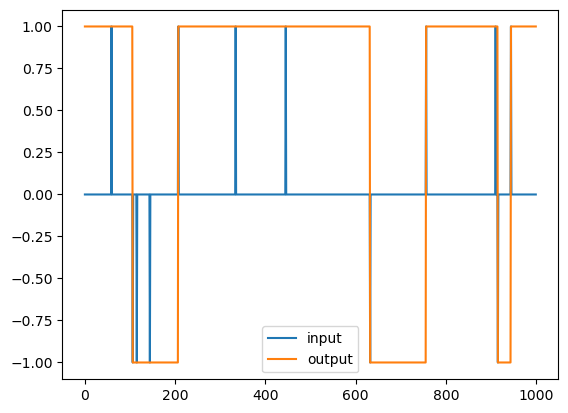

In [375]:
n_start = 0
n_steps = 1000
d = 0
# plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
# plt.subplot(2, 1, 1)
plt.plot(u[n_start:(n_start + n_steps), d], label = 'input')
# plt.legend()
# plt.show()
# plt.subplot(2, 1, 2)
plt.plot(y[n_start:(n_start + n_steps), d], label='output')
plt.legend()
plt.show()

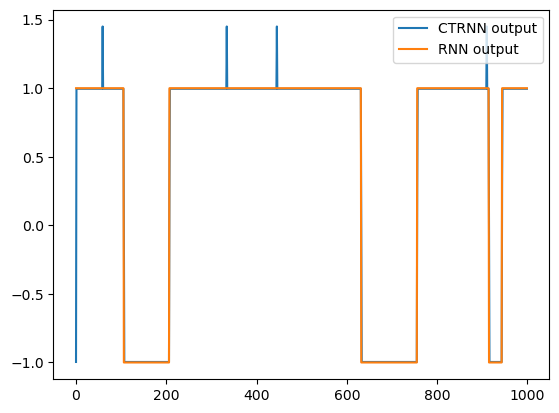

In [376]:
n_start = 0
n_steps = 1000
n_end = n_start + n_steps
# plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end], label='CTRNN output')
# plt.ylim([-1.2, 1.2])
# plt.legend()
# plt.subplot(2, 1, 2)
# plt.plot(internal_state.detach().numpy()[n_start:n_end], label='actual')
plt.plot(y[n_start:n_end], label = 'RNN output')
# plt.plot(u[n_start:n_end], label = 'input')
plt.legend()
plt.show()


In [371]:
extractor.p

tensor([-0.7000,  1.0000,  0.0000])

In [242]:
n_start = 0
n_steps = 100
n_end = n_start + n_steps
# plt.subplot(2, 1, 1)
plt.plot(y_out.detach().numpy()[n_start:n_end, 101], label='ena output')
# plt.legend()
# plt.show()
# plt.subplot(2, 2, 1)
plt.plot(internal_state.detach().numpy()[n_start:n_end, 101], label='actual')
# plt.plot(y[n_start:n_end], label = 'output')
plt.legend()
plt.show()

IndexError: index 101 is out of bounds for axis 1 with size 1

In [ ]:
plt.plot(lossHistory)
plt.show()

In [ ]:
# test on a new dataset

seq_len = 2_000
u, y, _ = sequence(seq_len, 0.01, 1, np.random.randint(0, 1e6))
# Wout_readout = torch.tensor(readout.params['Wout'])
# internal_state = torch.tensor(esn.run(u))
internal_state = torch.tensor(reservoir.run(u))
u, y = torch.tensor(u), torch.tensor(y)
y_out = torch.zeros((n_out, seq_len))
out = torch.zeros_like(y)
# h_out_all = torch.zeros_like((n_out, seq_len))

# Wout_readout = torch.tensor(readout.params['Wout'])
for t in range(seq_len):
    h_out = extractor.forward(u[t])
    # h_out = extractor.forward(internal_state[t])
    # out[t] = h_out
    # y_out_t = torch.matmul(h_out.float(), Wout.float()) + bias
    # y_out[t] = y_out_t
    out[t] = torch.matmul(h_out.float(), Wout_readout.float())

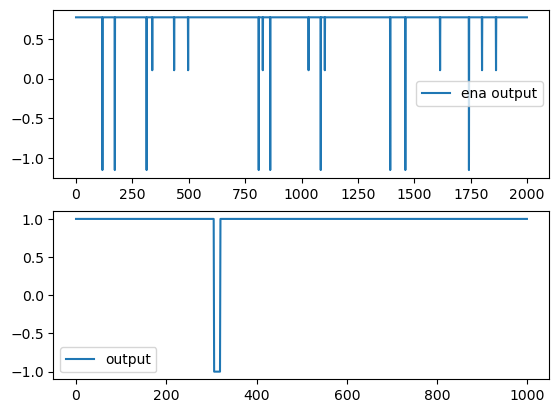

In [237]:
n_start = 0
n_steps = 2000
n_end = n_start + n_steps
plt.subplot(2, 1, 1)
plt.plot(out.detach().numpy()[n_start:n_end], label='ena output')
# plt.ylim([-1.2, 1.2])
plt.legend()
plt.subplot(2, 1, 2)
# plt.plot(internal_state.detach().numpy()[n_start:n_end, 1], label='actual')
plt.plot(y[n_start:n_end], label = 'output')
# plt.plot(u[n_start:n_end], label = 'input')
plt.legend()
plt.show()

In [ ]:
with open('ena_untrained_params.pkl', 'wb') as f:
    pickle.dump(extractor, f)

In [ ]:
extractor.Wp[:5,:5]

In [ ]:
### visualizing via dimensionality reduction
from sklearn.decomposition import PCA
ena_data = y_out.detach().numpy()


pca = PCA(n_components=3)
reduced=pca.fit_transform(ena_data)

In [ ]:
plt.plot(reduced[:, 0], reduced[:, 2])
plt.show()

In [ ]:
reduced[:, 0].max()